In [2]:
# manipulacja danymi
import numpy as np
import pandas as pd

# wizualizacja
import matplotlib.pyplot as plt
import seaborn as sns

# podział danych na zbiory treningowe/walidacyjne/testowe
from sklearn.model_selection import train_test_split, GridSearchCV

# budowa Pipeline
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer

# Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures, PowerTransformer

# redukcja wymiarowości
from sklearn.decomposition import PCA

# model
from sklearn.linear_model import LogisticRegression

# ewaluacja
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, f1_score, roc_auc_score

#metryki
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from math import sqrt

In [3]:
bike_data = pd.read_csv('daily-bike-share.csv')
bike_data

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,rentals
0,1,1/1/2011,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331
1,2,1/2/2011,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131
2,3,1/3/2011,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120
3,4,1/4/2011,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108
4,5,1/5/2011,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,727,12/27/2012,1,1,12,0,4,1,2,0.254167,0.226642,0.652917,0.350133,247
727,728,12/28/2012,1,1,12,0,5,1,2,0.253333,0.255046,0.590000,0.155471,644
728,729,12/29/2012,1,1,12,0,6,0,2,0.253333,0.242400,0.752917,0.124383,159
729,730,12/30/2012,1,1,12,0,0,0,1,0.255833,0.231700,0.483333,0.350754,364


In [4]:
X = bike_data.drop(['rentals'], axis=1).copy()
y = bike_data['rentals'].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [5]:
num_features = ['temp', 'atemp', 'hum', 'windspeed']
cat_features = ['season', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']

In [6]:
# przygotowanie wartości numerycznych
num_preparation = Pipeline(steps=[
    ('fill_missings', SimpleImputer(strategy='mean')),
    ('logtransformer', PowerTransformer()),
    ('polynomialfeatures', PolynomialFeatures(degree=3)),
    ('scaler_1', StandardScaler()),
    ('pca', PCA(n_components=0.95)),
    ('scaler_2', StandardScaler())
])

# przygotowanie wartości kategorycznych
cat_preparation = Pipeline(steps=[
    ('fill_missings', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(sparse=False ,handle_unknown='ignore'))
])

# transformer = wartości numeryczne oraz kategoryczne
data_preparation = ColumnTransformer(transformers=[
    ('numeric_preprocessing', num_preparation, num_features),
    ('categorical_preprocessing', cat_preparation, cat_features)
])

model_pipeline = Pipeline(steps=[('preprocessor', data_preparation),
                                    ('model', LogisticRegression(max_iter=10000))])
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric_preprocessing',
                                                  Pipeline(steps=[('fill_missings',
                                                                   SimpleImputer()),
                                                                  ('logtransformer',
                                                                   PowerTransformer()),
                                                                  ('polynomialfeatures',
                                                                   PolynomialFeatures(degree=3)),
                                                                  ('scaler_1',
                                                                   StandardScaler()),
                                                                  ('pca',
                                                                   PCA(n_components=0.95)),
                                                                  ('scaler_2',
                                                                   StandardScaler())]),
                                                  ['temp', 'atemp', 'hum',
                                                   'windspeed']),
                                                 ('categorical_preprocessing',
                                                  Pipeline(steps=[('fill_missings',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['season', 'mnth', 'holiday',
                                                   'weekday', 'workingday',
                                                   'weathersit'])])),
                ('model', LogisticRegression(max_iter=10000))])

R2 score =  0.9740640655256152
RMSE train =  108.98509857924967
RMSE test =  548.4356230708042


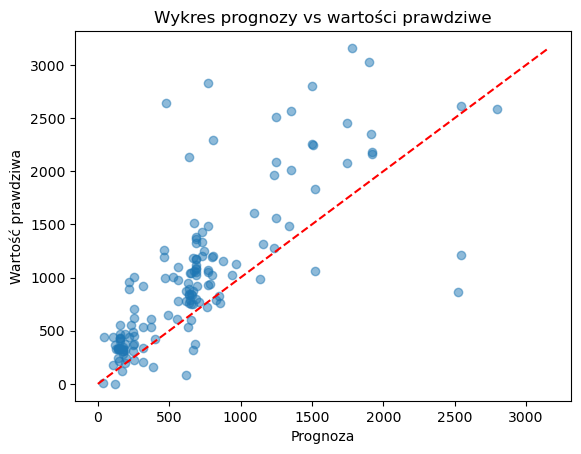

In [12]:
prediction_train = model_pipeline.predict(X_train)
prediction_test = model_pipeline.predict(X_test)

print('R2 score = ', r2_score(y_train, prediction_train))
print('RMSE train = ', sqrt(mean_squared_error(y_train, prediction_train)))
print('RMSE test = ', sqrt(mean_squared_error(y_test, prediction_test)))

plt.scatter(prediction_test, y_test, alpha=0.5)
plt.plot(np.arange(0, y_test.max()), np.arange(0, y_test.max()), color='red', linestyle='--')
plt.title('Wykres prognozy vs wartości prawdziwe')
plt.xlabel('Prognoza')
plt.ylabel('Wartość prawdziwa')
plt.show()